In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz96_fdm, M96
from assimilation import M3DVar, EnKF

In [22]:
X_nature = np.load('./L96/data/X_nature.npy')
X_ini = np.load('./L96/data/X_ini.npy')
obs = np.load('./L96/data/obs_normal.npy')
ts = np.load('./L96/data/time_span.npy')
Pb = np.load('./L96/data/Pb_assum.npy')
R = np.load('./L96/data/R.npy')

dt = 0.01

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# EnkF

In [23]:
params = {
    'X_ens_ini': X_ens_ini,
    'obs': obs,
    'obs_interv': 8,
    'R': R,
    'H_func': lambda arr: arr,
    'alpha': 0.3,
    'inflat': 1.5
}
enkf = EnKF(lorenz96_fdm, dt)
enkf.set_params(**params)
enkf.cycle()

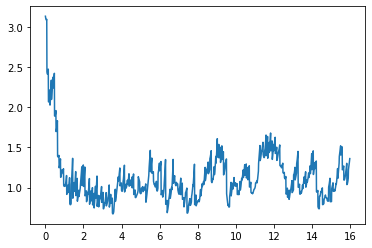

In [24]:
ensmean = enkf.analysis.mean(axis=0)
rmse = RMSE(ensmean, X_nature)
plt.plot(ts, rmse)

# 3DVar

In [25]:
params = {
    'X_ini': X_ini,
    'obs': obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
}
tdv = M3DVar(lorenz96_fdm, dt)
tdv.set_params(**params)
tdv.cycle()

0.9901124703727987


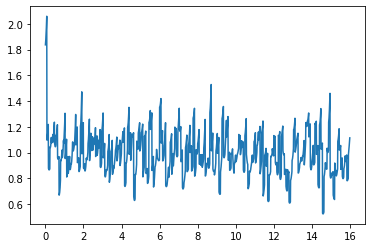

In [27]:
rmse = RMSE(tdv.analysis, X_nature)
plt.plot(ts, rmse)
print(rmse.mean())

### Skew

In [29]:
from scipy.stats import skewnorm

def gen_skewnormal(mean, var, alpha, size, random_state=None):
    """generate random number by skewnorm, and adjust them into given mean and variance"""
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # adjust var, then adjust mean
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

def gen_skewobs(nature, mean, var, alpha, obs_intv, random_state=None):
    """generate skew observations"""
    ndim, size = nature.shape
    
    if isinstance(mean, (int, float)):
        mean = [mean for _ in range(ndim)]
    if isinstance(var, (int, float)):
        var = [var for _ in range(ndim)]
    if isinstance(alpha, (int, float)):
        alpha = [alpha for _ in range(ndim)]
        
    if random_state is None:
        random_state = [np.random.randint(0, 100) for _ in range(ndim)]
    
    obs = np.zeros((ndim, size//obs_intv))
    for irow, (m, v, a, rst) in enumerate(zip(mean, var, alpha, random_state)):
        samples = gen_skewnormal(m, v, a, size, rst)
        #samples_tmp = samples.copy()
        #samples_tmp[::obs_intv] = 0
        #samples = samples - samples_tmp
        obs[irow,:] = (nature[irow,:] + samples)[::obs_intv]
        
    return obs

In [34]:
obs_intv = 8

enkf_params = {
    'X_ens_ini': X_ens_ini, 
    'obs_interv': obs_intv, 
    'R': R, 
    'H_func': None, 
    'alpha': 0.3,
    'inflat': 1.4
}

ekf_params = {
    'X_ini': X_ini,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'M': lambda X: M63(X.ravel(), dt),
    'alpha': 0.3,
    'inflat': 1.4
}

tdv_params = {
    'X_ini': X_ini,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
}

hy3denvar_params = {
    'X_ini': X_ini,
    'X_ens_ini': X_ens_ini,
    'obs_interv': obs_intv,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'alpha': 0.2,
    'inflat': 1.6,
    'beta': 0.5
}

da_params = {
    'enkf': enkf_params,
    'ekf': ekf_params,
    '3dvar': tdv_params,
    '3denvar': hy3denvar_params
}

In [53]:
alphas = [1.30, 1.55, 1.80, 2.05, 2.30, 2.55, 2.80, 3.05, 3.30]

da_schemes = ['enkf', '3dvar']
da_objs = [EnKF, M3DVar]

repeat_times = 10
for t in range(repeat_times):
    print(t)
    random_states = np.random.randint(0, 100, size=(len(alphas), 40))
    
    for da_obj, da_str in zip(da_objs, da_schemes):
        if da_str != '3dvar':
            continue
            
        for alpha, rsts in zip(alphas, random_states):
            print(da_str, alpha)
            
            obs = gen_skewobs(X_nature, 0, 2, alpha, obs_intv, rsts)

            da = da_obj(lorenz96_fdm, dt)
            params = da_params[da_str]
            params['obs'] = obs
            da.set_params(**params)
            da.cycle()

            path = './repeat_experiments_L96'
            fn = f'{path}/{da_str}_analysis_alpha{alpha*100:03.0f}_t{t}'
            if da_str != '3denvar':
                np.save(fn, da.analysis)
            else:
                np.save(fn, da.analysis_3dvar)

            fn = f'{path}/obs_alpha{alpha*100:03.0f}_t{t}'
            np.save(fn, obs)    

0
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
1
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
2
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
3
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
4
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
5
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
6
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
7
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
8
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
9
3dvar 1.3
3dvar 1.55
3dvar 1.8
3dvar 2.05
3dvar 2.3
3dvar 2.55
3dvar 2.8
3dvar 3.05
3dvar 3.3
